In [1]:
import os
import yaml
import time
import torch 
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
import joblib
from geopy.distance import geodesic
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split 
import numpy as np
from scipy.special import boxcox1p, inv_boxcox

# Personnal function
from functions_models import point_space_boundaries
from functions_models.collect_mini_cubes import *
from functions_models.apply_transformation import apply_transformation
from functions_models.fill_nan_with_mean import fill_nan_with_mean
from functions_models.add_current import add_current
from functions_models.apply_bathy_mask import apply_bathy_mask
from functions_models.usefull_function_model import *
from functions_models.build_data_loader import build_data_loader
from functions_models.models_archi import *
from functions_models.create_new_training_folder import *
from functions_models.evaluate_model import *

In [2]:
def build_data_loader(image_size, model, pfts, device, batch_size, dataset, path_dico, threshold):
    
    space_buffer = int(image_size/2)
    path = f'./dataset/{dataset}/space_buffer_{space_buffer}_date_buffer_1/threshold_{threshold}/'

    if model == 3:
        picture = torch.load(os.path.join(path, f'final_picture_{image_size}x{image_size}_CNN_boxcox.pt'), weights_only=False)
        df = torch.load(os.path.join(path, f'final_df_{image_size}x{image_size}_CNN_boxcox.pt'), weights_only=False)
    else : 
        picture = torch.load(os.path.join(path, f'final_picture_{image_size}x{image_size}_MLP_boxcox.pt'), weights_only=False)
        df = torch.load(os.path.join(path, f'final_df_{image_size}x{image_size}_MLP_boxcox.pt'), weights_only=False)

    valid_mask = ~torch.isnan(df[:, 6])
    picture = picture[valid_mask]
    df = df[valid_mask]

    if model == 1:
        inputs = picture[:, 8:14, :, :].to(device)
    else:
        inputs = picture[:, :14, :, :].to(device)

   
    target = df[:, 5].to(device)
    if pfts:
        target = df[:, 6:9].to(device)
    set_column = df[:, 9].to(device)
    benchmark = df[:, 14].to(device)
    if pfts:
        benchmark = df[:, 15:18].to(device)

    train_mask = set_column == 0
    val_mask = set_column == 1
    test_mask = set_column == 2

    train_inputs = inputs[train_mask]
    train_target = target[train_mask]
    train_benchmark = benchmark[train_mask]

    # Data augmentation: ensure low_target and high_target each represent 5% of the training data
    data_augmentation = False
    if data_augmentation:
            total_samples = len(train_target)
            print("Total samples before augmentation:", total_samples)
    
            nb_groups = 5
            bin_edges = torch.linspace(train_target.min(), train_target.max(), steps=nb_groups+1).to(train_target.device)
            bin_indices = torch.bucketize(train_target, bin_edges, right=True) - 1 
    
            frequencies = torch.bincount(bin_indices).float()
            frequencies[frequencies == 0] = 1e-6  # éviter la division par 0
    
            duplication_factors = (1.0 / frequencies**0.5)
            duplication_factors *= (total_samples / duplication_factors.sum())  # normalisation globale
            duplication_factors = duplication_factors.int()
    
            augmented_inputs, augmented_targets, augmented_benchmarks = [], [], []
    
            for bin_id in range(10):
                mask = bin_indices == bin_id
                num_duplicates = duplication_factors[bin_id].item()
    
                if num_duplicates > 0 and mask.sum() > 0:
                    augmented_inputs.append(train_inputs[mask].repeat(num_duplicates, 1, 1, 1))
                    augmented_targets.append(train_target[mask].repeat(num_duplicates))
                    augmented_benchmarks.append(train_benchmark[mask].repeat(num_duplicates))
    
            
            train_inputs = torch.cat([train_inputs] + augmented_inputs)
            train_target = torch.cat([train_target] + augmented_targets)
            train_benchmark = torch.cat([train_benchmark] + augmented_benchmarks)
    
            print("Total samples after augmentation:", len(train_target))

    train_dataset = TensorDataset(train_inputs, train_target, train_benchmark)
    valid_dataset = TensorDataset(inputs[val_mask], target[val_mask], benchmark[val_mask])
    test_dataset = TensorDataset(inputs[test_mask], target[test_mask], benchmark[test_mask])
    
    # In this case, we do not shuffle the train data.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Ajout : sortie TCHLA (colonne 5) pour chaque split, même si pfts=True
    train_tchla = df[train_mask, 5].to(device)
    val_tchla = df[val_mask, 5].to(device)
    test_tchla = df[test_mask, 5].to(device)

    return train_loader, valid_loader, test_loader, df, train_tchla, val_tchla, test_tchla


In [3]:
def build_data_loader(image_size, model, pfts, device, batch_size, dataset, path_dico, threshold):
    
    space_buffer = int(image_size/2)
    path = f'./dataset/{dataset}/space_buffer_{space_buffer}_date_buffer_1/threshold_{threshold}/'

    if model == 3:
        picture = torch.load(os.path.join(path, f'final_picture_{image_size}x{image_size}_CNN_boxcox.pt'), weights_only=False)
        df = torch.load(os.path.join(path, f'final_df_{image_size}x{image_size}_CNN_boxcox.pt'), weights_only=False)
    else : 
        picture = torch.load(os.path.join(path, f'final_picture_{image_size}x{image_size}_MLP_boxcox.pt'), weights_only=False)
        df = torch.load(os.path.join(path, f'final_df_{image_size}x{image_size}_MLP_boxcox.pt'), weights_only=False)

    valid_mask = ~torch.isnan(df[:, 6])
    picture = picture[valid_mask]
    df = df[valid_mask]

    if model == 1:
        inputs = picture[:, 8:14, :, :].to(device)
    else:
        inputs = picture[:, :14, :, :].to(device)

   
    target = df[:, 5].to(device)
    tchla_value = df[:, 5].to(device)
    fraction_community = df[:, 11:14].to(device) 
    if pfts:
        target = df[:, 6:9].to(device)
    set_column = df[:, 9].to(device)
    benchmark = df[:, 14].to(device)
    if pfts:
        benchmark = df[:, 15:18].to(device)

    train_mask = set_column == 0
    val_mask = set_column == 1
    test_mask = set_column == 2

    train_inputs = inputs[train_mask]
    train_target = target[train_mask]
    train_benchmark = benchmark[train_mask]
    train_tchla_value = tchla_value[train_mask]
    train_fraction_community = fraction_community[train_mask]
    
    # Data augmentation: ensure low_target and high_target each represent 5% of the training data
    data_augmentation = False
    if data_augmentation:
            total_samples = len(train_target)
            print("Total samples before augmentation:", total_samples)
    
            nb_groups = 5
            bin_edges = torch.linspace(train_target.min(), train_target.max(), steps=nb_groups+1).to(train_target.device)
            bin_indices = torch.bucketize(train_target, bin_edges, right=True) - 1 
    
            frequencies = torch.bincount(bin_indices).float()
            frequencies[frequencies == 0] = 1e-6  # éviter la division par 0
    
            duplication_factors = (1.0 / frequencies**0.5)
            duplication_factors *= (total_samples / duplication_factors.sum())  # normalisation globale
            duplication_factors = duplication_factors.int()
    
            augmented_inputs, augmented_targets, augmented_benchmarks = [], [], []
    
            for bin_id in range(10):
                mask = bin_indices == bin_id
                num_duplicates = duplication_factors[bin_id].item()
    
                if num_duplicates > 0 and mask.sum() > 0:
                    augmented_inputs.append(train_inputs[mask].repeat(num_duplicates, 1, 1, 1))
                    augmented_targets.append(train_target[mask].repeat(num_duplicates))
                    augmented_benchmarks.append(train_benchmark[mask].repeat(num_duplicates))
    
            
            train_inputs = torch.cat([train_inputs] + augmented_inputs)
            train_target = torch.cat([train_target] + augmented_targets)
            train_benchmark = torch.cat([train_benchmark] + augmented_benchmarks)
    
            print("Total samples after augmentation:", len(train_target))

    train_dataset = TensorDataset(train_inputs, train_target, train_benchmark, train_tchla_value, train_fraction_community)
    valid_dataset = TensorDataset(inputs[val_mask], target[val_mask], benchmark[val_mask], tchla_value[val_mask], fraction_community[val_mask])
    test_dataset = TensorDataset(inputs[test_mask], target[test_mask], benchmark[test_mask], tchla_value[test_mask], fraction_community[test_mask])
    
    # In this case, we do not shuffle the train data.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    return train_loader, valid_loader, test_loader, df




In [4]:
# ¨Parameters that you don't change
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = "from_pfts_study_reset17072025"
image_size = 16
date_buffer = 1
space_buffer = int(image_size/2)
threshold = 0.99
model = 1
pfts = True 

#Hyper parameters 
learning_rate = 7*10e-4
batch_size = 100
nb_epoch = 6000


nb_training = 1

# Parameters for scatter plot 
main_title = f'MLP on {image_size}x{image_size} km with optics input'
y_label_name = f'MLP'
model_save_name = "MLP_1.pth"


# Load data 
path_dico = f"./dataset/{dataset}/space_buffer_{space_buffer}_date_buffer_1/threshold_{threshold}"
train_loader, valid_loader, test_loader, df_mini_cubes = build_data_loader(image_size, model, pfts, 'cpu', batch_size, dataset, path_dico, threshold)
criterion = nn.MSELoss()
#optimizer = optim.Adam(model_dl.parameters(), lr=learning_rate)


In [5]:
# 1) Load the best TCHLA model, you can select the mode between 
    # 1 - Only Optics - best model in function of the validation score - 22
    # 2 - All Optics and physics - best model in function of the validation score - 11
    # 3 - Optics and physics selected by the method  - best model in function of the validation score -

mode = 1
login = "/home/elabourdette"
if mode == 1:
    num_model_tchla = 22 
    model_tchla_path = f"./model_save_tchla_best_training/model_1/train_{num_model_tchla}/MLP_1.pth"
    model_dl_tchla = DNN(6, [70], 1, device,p=0) 
elif mode == 2:
    num_model_tchla = 11
    model_tchla_path = f"./model_save_tchla_best_training/model_2/train_{num_model_tchla}/MLP_2.pth"
    model_dl_tchla = DNN(14, [100], 1, device,p=0) 
elif mode == 3:
    # For the moment this model is not the best configuration. I have to remake the training with the new points added by the features selection. 
    num_model_tchla = 10
    #model_tchla_path = f"{login}/complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process_select_variables/training_TCHLA_all_threshold_0.99/space_buffer_8_date_buffer_1/model_SST/train_{num_model_tchla}/MLP_SST.pth"
    model_dl_tchla = DNN(6, [100], 1, device,p=0) 

# Download the model 
model_dl_tchla.to(device)
checkpoint = torch.load(model_tchla_path, map_location=device)
model_dl_tchla.load_state_dict(checkpoint['model_state_dict'])
model_dl_tchla.eval().to(device)

# Make tchla prediction on all the dataset
prediction_train_tchla, prediction_val_tchla, prediction_test_tchla = [], [], []

train_tchla_value, val_tchla_value, test_tchla_value = [], [], []  
train_frac_commu_list, val_frac_commu_list, test_frac_commu_list = [], [], [] 
with torch.no_grad():
    for loader, pred_list, tchla_list, frac_commu_list in zip([train_loader, valid_loader, test_loader], [prediction_train_tchla, prediction_val_tchla, prediction_test_tchla], [train_tchla_value, val_tchla_value, test_tchla_value], [train_frac_commu_list, val_frac_commu_list, test_frac_commu_list]):
        for images, community_value, _, tchla_value, frac_value in loader:
            images = images.to(device)
            images[images == -10] = float('nan')
            images = images.nanmean(dim=(2, 3))
            outputs = model_dl_tchla(images.float())
            pred_list.append(outputs.view(-1).cpu().numpy())
            tchla_list.append(tchla_value.view(-1).cpu().numpy())
            frac_commu_list.append(frac_value.cpu().numpy())

prediction_train_tchla = torch.tensor(np.concatenate(prediction_train_tchla))
prediction_val_tchla = torch.tensor(np.concatenate(prediction_val_tchla))
prediction_test_tchla = torch.tensor(np.concatenate(prediction_test_tchla))

train_tchla = torch.tensor(np.concatenate(train_tchla_value))
val_tchla = torch.tensor(np.concatenate(val_tchla_value))
test_tchla = torch.tensor(np.concatenate(test_tchla_value))

frac_train = torch.tensor(np.concatenate(train_frac_commu_list))
frac_val = torch.tensor(np.concatenate(val_frac_commu_list))
frac_test = torch.tensor(np.concatenate(test_frac_commu_list))


/tmp/ipykernel_2454507/942574598.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_tchla_path, map_location=device)


In [6]:
# Remove the transformation 
data_to_use = "boxcox"
path_dico = f"./dataset/{dataset}/space_buffer_{space_buffer}_date_buffer_1/threshold_{threshold}"
json_path = os.path.join(path_dico, "dico_lambda_MLP.json")
with open(json_path, "r") as f:
    dico = json.load(f)

# --- Modular TCHLA post-processing for train, val, test ---
def postprocess_tchla(pred_tensor, true_tensor, dico, key, short_key, data_to_use):
    pred_arr = pred_tensor.detach().cpu().numpy().reshape(-1, 1)
    true_arr = true_tensor.detach().cpu().numpy().reshape(-1, 1)
    if data_to_use == "quantile":
        TChla_path = os.path.join(path_dico, "TChla_quantile_transformer.pkl")
        quantile_transformer = joblib.load(TChla_path)
        pred_arr = quantile_transformer.inverse_transform(pred_arr)
        true_arr = quantile_transformer.inverse_transform(true_arr)
    elif data_to_use == "boxcox":
        mean = dico[f"{key}_standardization_mean"]
        std = dico[f"{key}_standardization_std"]
        pred_arr = pred_arr * std + mean
        true_arr = true_arr * std + mean
        lmbda = dico[f"{key}_boxcox_lmbda"]
        pred_arr = inv_boxcox(pred_arr, lmbda)
        true_arr = inv_boxcox(true_arr, lmbda)
        pred_arr = pred_arr - 10e-4
        true_arr = true_arr - 10e-4
    pred_arr[pred_arr < 0.0001] = 0.0
    true_arr[true_arr < 0.0001] = 0.0
    return {
        f"{short_key}_pred": pred_arr.flatten().tolist(),
        f"{short_key}_true": true_arr.flatten().tolist()
    }

key = "TChla"
short_key = "tchla"

tchla_train_dict = postprocess_tchla(prediction_train_tchla, train_tchla, dico, key, short_key, data_to_use)
tchla_val_dict   = postprocess_tchla(prediction_val_tchla, val_tchla, dico, key, short_key, data_to_use)
tchla_test_dict  = postprocess_tchla(prediction_test_tchla, test_tchla, dico, key, short_key, data_to_use)

# Les dictionnaires tchla_train_dict, tchla_val_dict, tchla_test_dict contiennent les valeurs post-traitées pour chaque split



In [7]:
row_sums = frac_train.sum(dim=1)

# Vérification avec une tolérance
tolerance = 1e-5
not_equal = torch.abs(row_sums - 1.0) > tolerance

# Résultat
print(f"Nombre de lignes ≠ 1.0 : {not_equal.sum().item()}")

Nombre de lignes ≠ 1.0 : 0


In [8]:
train_tchla
# Multiply standardized true TCHLA (torch tensor) with commu_X (torch tensor)
train_commu = train_tchla.unsqueeze(1) * frac_train
val_commu = val_tchla.unsqueeze(1) * frac_val
test_commu = test_tchla.unsqueeze(1) * frac_test

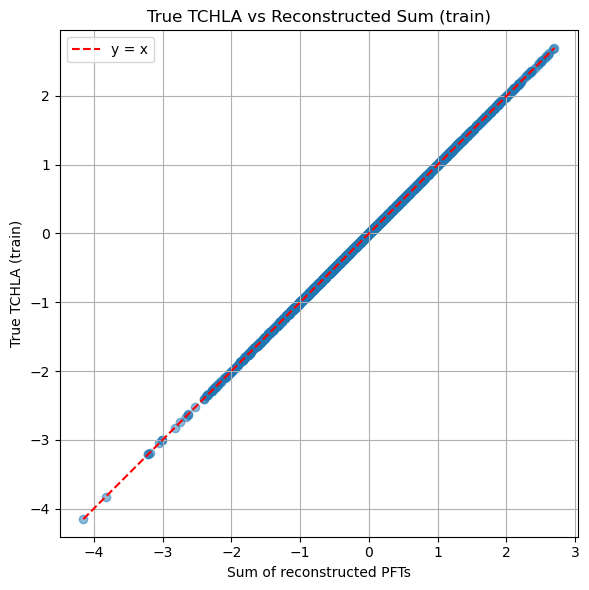

In [9]:
import matplotlib.pyplot as plt

# Somme des PFTs reconstruits (micro + nano + pico)
train_commu_sum = train_commu.sum(dim=1)

# tchla_true_train est déjà shape [N, 1] → on squeeze pour [N]
tchla_true_train_flat = train_tchla

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(train_commu_sum.cpu(), tchla_true_train_flat.cpu(), alpha=0.5)
plt.plot([tchla_true_train_flat.min(), tchla_true_train_flat.max()],
         [tchla_true_train_flat.min(), tchla_true_train_flat.max()],
         'r--', label='y = x')

plt.xlabel("Sum of reconstructed PFTs")
plt.ylabel("True TCHLA (train)")
plt.title("True TCHLA vs Reconstructed Sum (train)")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


In [10]:
# KDE Plotly : mêmes couleurs que seaborn/matplotlib pour TCHLA True et Pred (Train/Val/Test)
import plotly.graph_objects as go
import numpy as np
from scipy.stats import gaussian_kde

def kde_curve(data, bw_method=0.2, n_points=500):
    kde = gaussian_kde(data, bw_method=bw_method)
    x_grid = np.linspace(np.min(data), np.max(data), n_points)
    y_grid = kde(x_grid)
    return x_grid, y_grid

# Couleurs identiques à seaborn/matplotlib
split_colors = {
    'Train': ('blue', 'rgba(0,0,255,0.2)'),
    'Validation': ('green', 'rgba(0,128,0,0.2)'),
    'Test': ('red', 'rgba(255,0,0,0.2)')
}

# Plotly KDE pour les valeurs TCHLA vraies et prédites avec des couleurs de séparation cohérentes
fig = go.Figure()
splits = ['Train', 'Validation', 'Test']
tchla_true_dict = {'Train': train_tchla, 'Validation': val_tchla, 'Test': test_tchla}
tchla_pred_dict = {'Train': prediction_train_tchla, 'Validation': prediction_val_tchla, 'Test': prediction_test_tchla}
for split in splits:
    color, fill_color = split_colors[split]
    # Valeurs réelles
    kde_true = gaussian_kde(tchla_true_dict[split])
    x_true = np.linspace(np.min(tchla_true_dict[split].cpu().numpy()), np.max(tchla_true_dict[split].cpu().numpy()), 200)
    y_true = kde_true(x_true)
    fig.add_trace(go.Scatter(x=x_true, y=y_true, mode='lines', name=f'{split} True',
                             line=dict(color=color, width=2),
                             fill='tozeroy', fillcolor=fill_color, opacity=1))
    # Valeurs prédites
    kde_pred = gaussian_kde(tchla_pred_dict[split])
    x_pred = np.linspace(np.min(tchla_pred_dict[split]), np.max(tchla_pred_dict[split]), 200)
    y_pred = kde_pred(x_pred)
    fig.add_trace(go.Scatter(x=x_pred, y=y_pred, mode='lines', name=f'{split} Pred',
                             line=dict(color=color, dash='dash', width=2),
                             fill='tozeroy', fillcolor=fill_color, opacity=0.7))
fig.update_layout(title='KDE des valeurs TCHLA vraies et prédites par séparation',
                  xaxis_title='Standardized log10 TCHLA',
                  yaxis_title='Density',
                  legend_title='Split',
                  template='plotly_white')
fig.show()

TypeError: min() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis


In [ ]:
import plotly.graph_objects as go
import numpy as np
from scipy.stats import gaussian_kde

def kde_curve(data, bw_method=0.2, n_points=500):
    kde = gaussian_kde(data, bw_method=bw_method)
    x_grid = np.linspace(np.min(data), np.max(data), n_points)
    y_grid = kde(x_grid)
    return x_grid, y_grid

# Couleurs identiques à seaborn/matplotlib
split_colors = {
    'Train': ('blue', 'rgba(0,0,255,0.2)'),
    'Validation': ('green', 'rgba(0,128,0,0.2)'),
    'Test': ('red', 'rgba(255,0,0,0.2)')
}

# Dictionnaires de données
splits = ['Train', 'Validation', 'Test']
tchla_true_dict = {
    'Train': train_tchla,
    'Validation': val_tchla,
    'Test': test_tchla
}
tchla_pred_dict = {
    'Train': prediction_train_tchla,
    'Validation': prediction_val_tchla,
    'Test': prediction_test_tchla
}

# --- Figure pour les valeurs TRUE ---
fig_true = go.Figure()
for split in splits:
    color, fill_color = split_colors[split]
    true_data = tchla_true_dict[split].cpu().numpy()
    x_true, y_true = kde_curve(true_data)
    fig_true.add_trace(go.Scatter(
        x=x_true, y=y_true,
        mode='lines',
        name=f'{split} True',
        line=dict(color=color, width=2),
        fill='tozeroy',
        fillcolor=fill_color,
        opacity=1
    ))

fig_true.update_layout(
    title='KDE des valeurs TCHLA vraies par split',
    xaxis_title='Standardized log10 TCHLA',
    yaxis_title='Density',
    legend_title='Split',
    template='plotly_white'
)

# --- Figure pour les valeurs PRED ---
fig_pred = go.Figure()
for split in splits:
    color, fill_color = split_colors[split]
    pred_tensor = tchla_pred_dict[split]
    pred_data = pred_tensor.cpu().numpy() if hasattr(pred_tensor, 'cpu') else np.asarray(pred_tensor)
    x_pred, y_pred = kde_curve(pred_data)
    fig_pred.add_trace(go.Scatter(
        x=x_pred, y=y_pred,
        mode='lines',
        name=f'{split} Pred',
        line=dict(color=color, dash='dash', width=2),
        fill='tozeroy',
        fillcolor=fill_color,
        opacity=0.7
    ))

fig_pred.update_layout(
    title='KDE des valeurs TCHLA prédites par split',
    xaxis_title='Standardized log10 TCHLA',
    yaxis_title='Density',
    legend_title='Split',
    template='plotly_white'
)

# Affichage
fig_true.show()
fig_pred.show()



In [ ]:
import plotly.graph_objects as go
import numpy as np
from scipy.stats import gaussian_kde

# Données en entrée (remplacez par vos propres arrays)
# train_commu = np.array([...])  # shape (n_train, 3)
# val_commu = np.array([...])    # shape (n_val, 3)
# test_commu = np.array([...])   # shape (n_test, 3)

# Association des splits
split_colors = {
    'Train': ('blue', 'rgba(0,0,255,0.2)'),
    'Validation': ('green', 'rgba(0,128,0,0.2)'),
    'Test': ('red', 'rgba(255,0,0,0.2)')
}
splits = ['Train', 'Validation', 'Test']
commu_data = {
    'Train': train_commu,
    'Validation': val_commu,
    'Test': test_commu
}

# Noms des dimensions
dimensions = ['micro', 'nano', 'pico']
col_index = {'micro': 0, 'nano': 1, 'pico': 2}

# Génération de KDE plots pour chaque dimension
for dim in dimensions:
    fig = go.Figure()
    for split in splits:
        color, fill_color = split_colors[split]
        data_array = commu_data[split][:, col_index[dim]]
        x_vals = np.linspace(data_array.min(), data_array.max(), 200)
        y_vals = gaussian_kde(data_array)(x_vals)

        fig.add_trace(go.Scatter(
            x=x_vals, y=y_vals, mode='lines', name=f'{split} {dim} True',
            line=dict(color=color, width=2),
            fill='tozeroy', fillcolor=fill_color, opacity=1
        ))

    fig.update_layout(
        title=f'KDE {dim} (True) - Train/Val/Test',
        xaxis_title=f'Standardized log10 {dim}',
        yaxis_title='Density',
        legend_title='Split',
        template='plotly_white'
    )
    fig.show()


In [21]:
# 2) Create the model for PFTS prediction. This model make the prediction for only Micro and Nano Chla. 
#    We will then deduce the pico CHLA buy using Tchla - (Nano + Micro).

if model == 1:
    model_dl = DNN(6, [70,50], 2, device,p=0.1)
    #model_dl = DNN(6, [70,50], 3, device,p=0.1)
elif model == 2:
    model_dl = DNN(14, [100,50], 2, device,p=0.3) 
elif model == 3:
    print("not implemented yet")

model_dl.to(device)
optimizer = optim.Adam(model_dl.parameters(), lr=learning_rate)

In [22]:
# Legend for DataLoader batch indices:
# batch[0]: inputs
# batch[1]: targets (PFTs or TCHLA)
# batch[2]: benchmarks
# batch[3]: true TCHLA values
# batch[4]: fraction community (micro, nano, pico)
# batch[5]: predicted TCHLA (added by build_loader_with_pred)


# attention changer tagets par train_commu, val_commu et test_commu en fonction du mode
def build_loader_with_pred(loader, tchla_pred, new_targets, shuffle):
    """
    Returns a DataLoader where each batch contains:
    [inputs, new_targets (fraction community), benchmarks, true_tchla, frac_commu, tchla_pred]
    """
    inputs, benchmarks, tchla, frac_commu = [], [], [], []
    
    for batch in loader:
        inputs.append(batch[0])
        benchmarks.append(batch[2])
        tchla.append(batch[3])
        frac_commu.append(batch[4])

    inputs = torch.cat(inputs)
    benchmarks = torch.cat(benchmarks)
    tchla = torch.cat(tchla)
    frac_commu = torch.cat(frac_commu)
    
    new_targets = new_targets.to(inputs.device)
    tchla_pred = tchla_pred.to(inputs.device)

    assert new_targets.shape[0] == inputs.shape[0], "Mismatch in number of samples between inputs and new_targets"

    dataset_with_pred = TensorDataset(inputs, new_targets, benchmarks, tchla, frac_commu, tchla_pred)
    return DataLoader(dataset_with_pred, batch_size=batch_size, shuffle=shuffle)


In [23]:
train_loader_pfts = build_loader_with_pred(train_loader, prediction_train_tchla, train_commu, shuffle=True)
valid_loader_pfts = build_loader_with_pred(valid_loader, prediction_val_tchla, val_commu, shuffle=False)
test_loader_pfts  = build_loader_with_pred(test_loader, prediction_test_tchla, test_commu, shuffle=False)


In [24]:
# Inspect the shape of each parameter in a batch from train_loader_pfts
batch = next(iter(train_loader_pfts))
for i, param in enumerate(batch):
    print(f"Parameter {i} shape: {param.shape}")

Parameter 0 shape: torch.Size([100, 6, 4, 4])
Parameter 1 shape: torch.Size([100, 3])
Parameter 2 shape: torch.Size([100, 3])
Parameter 3 shape: torch.Size([100])
Parameter 4 shape: torch.Size([100, 3])
Parameter 5 shape: torch.Size([100])


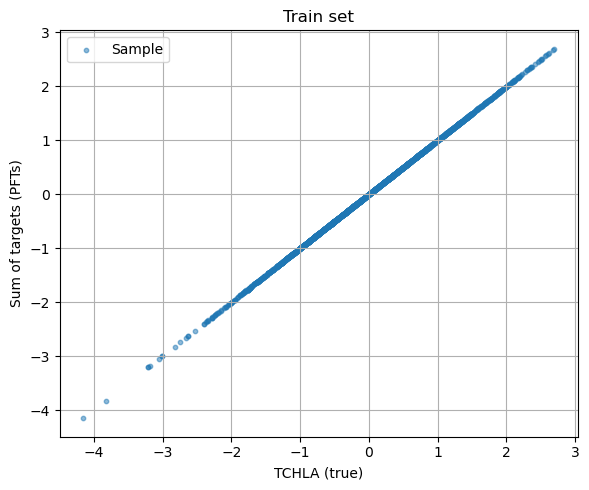

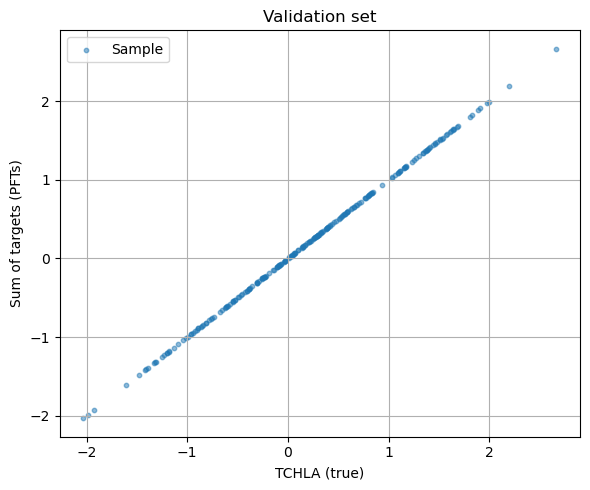

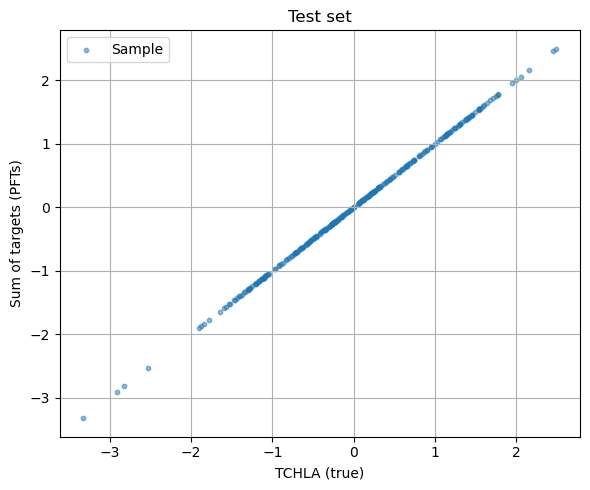

In [25]:
import torch
import matplotlib.pyplot as plt

def plot_sum_targets_vs_tchla(loader, title="Sum of targets vs TCHLA"):
    all_tchla = []
    all_sum_targets = []

    for batch in loader:
        targets = batch[1]       # shape: (batch_size, 3) -> PFTs
        tchla = batch[3]         # shape: (batch_size,)

        sum_targets = targets.sum(dim=1)  # sum of PFTs per sample

        all_sum_targets.append(sum_targets.cpu())
        all_tchla.append(tchla.cpu())

    all_sum_targets = torch.cat(all_sum_targets).numpy()
    all_tchla = torch.cat(all_tchla).numpy()

    plt.figure(figsize=(6, 5))
    plt.scatter(all_tchla, all_sum_targets, alpha=0.5, s=10, label="Sample")
    plt.xlabel("TCHLA (true)")
    plt.ylabel("Sum of targets (PFTs)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_sum_targets_vs_tchla(train_loader_pfts, title="Train set")
plot_sum_targets_vs_tchla(valid_loader_pfts, title="Validation set")
plot_sum_targets_vs_tchla(test_loader_pfts, title="Test set")


In [26]:
import torch 
import copy
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

def train_val_loop_l2(device, nb_epoch, model_dl, dataloader_train, dataloader_val,
                   optimizer, criterion, loss_diff_threshold, model, 
                   prediction_train_tchla, prediction_val_tchla, patience=50,
                   use_penalty=False, penalty_type="L2", penalty_lambda=7*1e-4):
    """
    Custom training loop for PFTs prediction. Computes MSE for micro, nano, and pico.
    Inputs:
        prediction_train_tchla: tensor of TCHLA predictions for train set
        prediction_val_tchla: tensor of TCHLA predictions for val set
    """

    model_dl.to(device)

    LOSS_TRAIN = []
    LOSS_VAL = []
    list_val = []
    best_val_loss = float('inf')
    best_model_state = copy.deepcopy(model_dl.state_dict())
    epoch_iterator = tqdm(range(nb_epoch), desc="Training epochs")

    for epoch in epoch_iterator:
        total_loss_train = 0
        model_dl.train()
        idx_train = 0
        for X_batch, Y_batch, _, _, _, tchla_pred in dataloader_train:
            if model != 3:
                X_batch[X_batch == -10] = float('nan')
                X_batch = X_batch.nanmean(dim=(2, 3))

            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()

            prediction = model_dl(X_batch.float())  # shape: [batch, 2] (micro, nano)
            micro_pred = prediction[:, 0].view(-1, 1)
            nano_pred = prediction[:, 1].view(-1, 1)
            #pico_pred = prediction[:, 2].view(-1, 1)
            # Calculate pico_pred as TCHLA - micro - nano
            #tchla_pred = tchla_pred.view(-1, 1).to(device)
            #pico_pred = tchla_pred - micro_pred - nano_pred
            
            # Concaténer les trois prédictions
            prediction_tensor = torch.cat([micro_pred, nano_pred], dim=1)
            truth_tensor = Y_batch[:, :2]

            #prediction_tensor = torch.cat([micro_pred, nano_pred, pico_pred], dim=1)
            #truth_tensor = Y_batch[:, :3]  # micro, nano, pico

            # Appliquer le critère sur tout le tensor
            loss = criterion(prediction_tensor, truth_tensor)

            # Add L2 penalty
            if use_penalty and penalty_type == "L2":
                l2_penalty = sum(torch.sum(param**2) for param in model_dl.parameters())
                loss += penalty_lambda * l2_penalty

            loss.backward()
            total_loss_train += loss.item()
            optimizer.step()
            idx_train += len(X_batch)

        average_loss_train = total_loss_train / len(dataloader_train)
        LOSS_TRAIN.append(average_loss_train)

        if (epoch + 1) % 2 == 0:
            total_loss_val = 0
            model_dl.eval()
            idx_val = 0
            with torch.no_grad():
                for X_batch_val, Y_batch_val, _, _, _, tchla_pred_val in dataloader_val:
                    if model != 3:
                        X_batch_val[X_batch_val == -10] = float('nan')
                        X_batch_val = X_batch_val.nanmean(dim=(2, 3))

                    X_batch_val, Y_batch_val = X_batch_val.to(device), Y_batch_val.to(device)
                    prediction_val = model_dl(X_batch_val.float())
                    micro_pred = prediction_val[:, 0].view(-1, 1)
                    nano_pred = prediction_val[:, 1].view(-1, 1)
                    #pico_pred = prediction_val[:, 2].view(-1, 1)
                    
                    tchla_pred = tchla_pred_val.view(-1, 1).to(device)
                    pico_pred = tchla_pred - micro_pred - nano_pred
                    
                    # Concaténer les trois prédictions
                    prediction_tensor = torch.cat([micro_pred, nano_pred], dim=1)
                    truth_tensor = Y_batch_val[:, :2]

                    #prediction_tensor = torch.cat([micro_pred, nano_pred, pico_pred], dim=1)
                    #truth_tensor = Y_batch_val[:, :3]

                    # Appliquer le critère sur tout le tensor
                    loss_val = criterion(prediction_tensor, truth_tensor)
                    total_loss_val += loss_val.item()
                    idx_val += len(X_batch_val)

            average_loss_val = total_loss_val / len(dataloader_val)
            LOSS_VAL.append(average_loss_val)
            list_val.append(average_loss_val)

            if average_loss_val < best_val_loss:
                best_val_loss = average_loss_val
                best_model_state = copy.deepcopy(model_dl.state_dict())

        if len(LOSS_TRAIN) >= patience and (epoch + 1) % 2 == 0:
            recent_losses = LOSS_VAL[-patience:]
            if max(recent_losses) - min(recent_losses) < loss_diff_threshold:
                print(f'Early stopping at epoch {epoch + 1} due to minimal change in validation loss over the last {patience} epochs')
                break

    model_dl.load_state_dict(best_model_state)

    return LOSS_TRAIN, LOSS_VAL, list_val, model_dl




In [ ]:
loss_diff_threshold = 0.002
LOSS_TRAIN, LOSS_VAL, list_val, model_trained = train_val_loop_l2(device, nb_epoch, model_dl, train_loader_pfts, valid_loader_pfts,
                   optimizer, criterion, loss_diff_threshold, model, 
                   prediction_train_tchla, prediction_val_tchla,
                   patience=50,
                   use_penalty=False, penalty_type="L2", penalty_lambda=7*1e-4)

Training epochs: 100%|██████████| 6000/6000 [20:22<00:00,  4.91it/s]


Plot saved as:
  • ./training_new_loss_pico_soustraction/model_1/space_buffer_8_date_buffer_1/train_pfts_15.png
  • ./training_new_loss_pico_soustraction/model_1/space_buffer_8_date_buffer_1/train_pfts_15.pdf


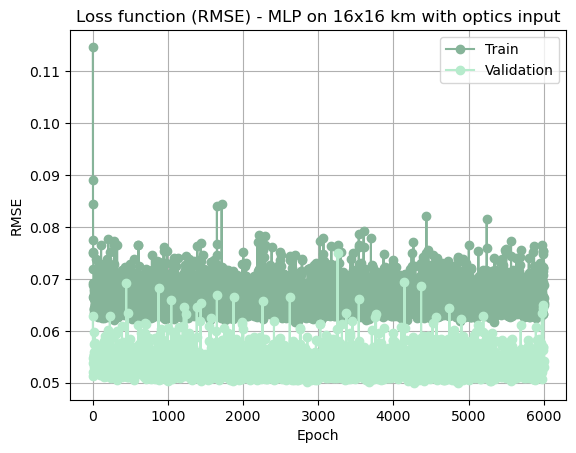

In [28]:
#make a save file 
training_name = "new_loss_pico_soustraction"
path_save = f"./training_{training_name}/model_{model}/space_buffer_{space_buffer}_date_buffer_{date_buffer}"
path_save_all = create_new_training_folder(path_save, pfts)

plot_loss(LOSS_TRAIN, LOSS_VAL, main_title, path_save_all, "RMSD")

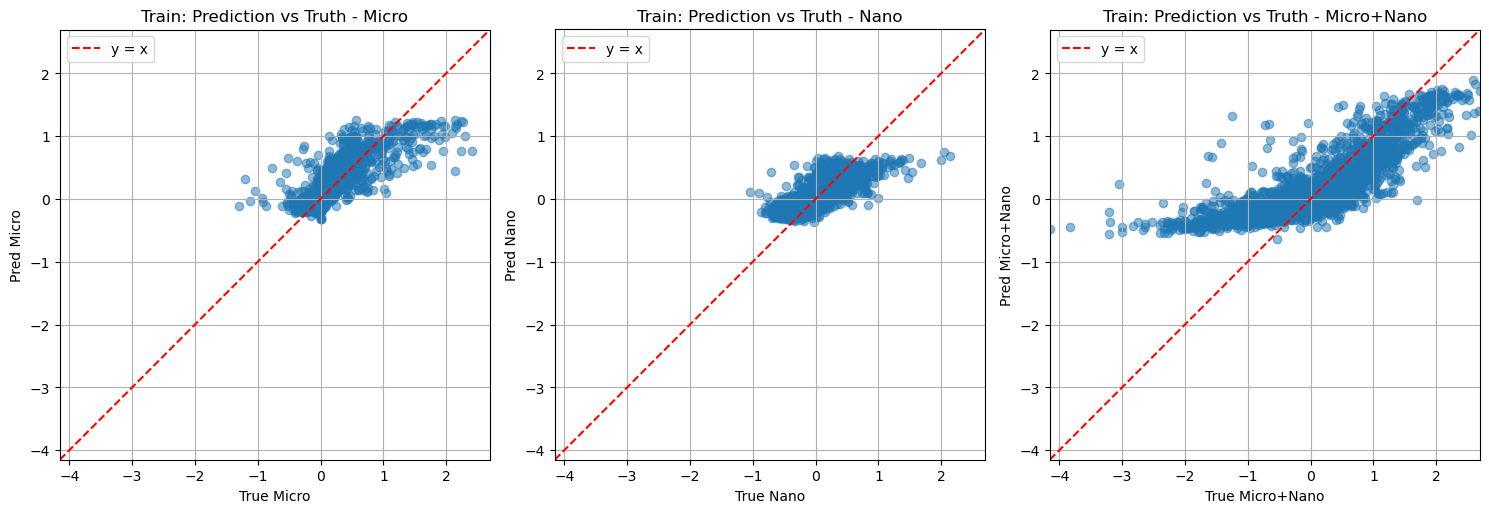

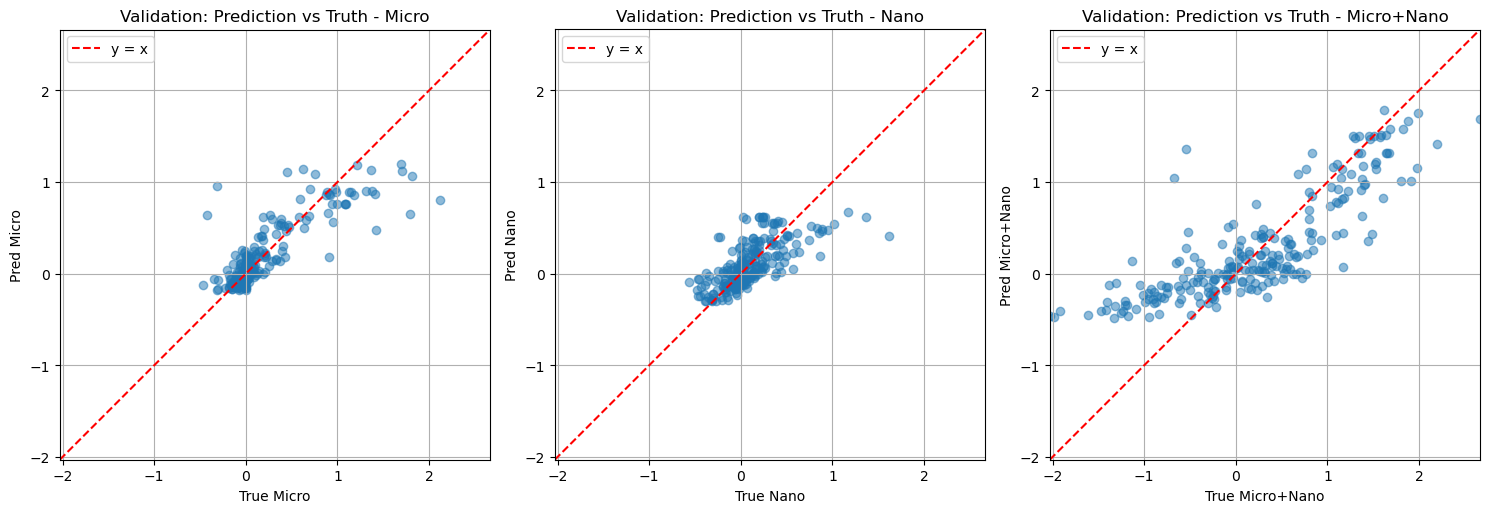

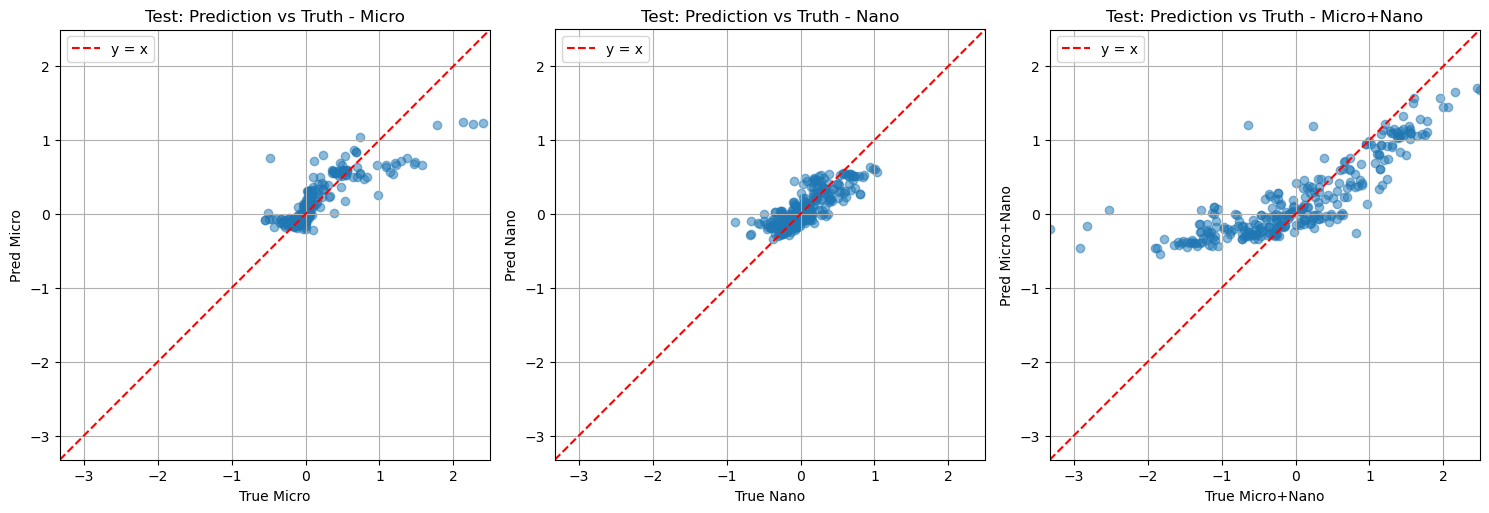

In [52]:
import matplotlib.pyplot as plt
def plot_pred_vs_true(loader, model, device, title):
    model.eval()
    preds_micro, preds_nano, preds_sum = [], [], []
    trues_micro, trues_nano, trues_sum = [], [], []
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0].to(device)
            targets = batch[1].to(device)
            if hasattr(inputs, 'nanmean'):
                inputs[inputs == -10] = float('nan')
                inputs = inputs.nanmean(dim=(2, 3))
            outputs = model(inputs.float())
            preds_micro.append(outputs[:, 0].cpu())
            preds_nano.append(outputs[:, 1].cpu())
            preds_sum.append(outputs.sum(dim=1).cpu())
            trues_micro.append(targets[:, 0].cpu())
            trues_nano.append(targets[:, 1].cpu())
            trues_sum.append(targets.sum(dim=1).cpu())

    preds_micro = torch.cat(preds_micro).numpy()
    preds_nano = torch.cat(preds_nano).numpy()
    preds_sum = torch.cat(preds_sum).numpy()
    trues_micro = torch.cat(trues_micro).numpy()
    trues_nano = torch.cat(trues_nano).numpy()
    trues_sum = torch.cat(trues_sum).numpy()

    all_true = np.concatenate([trues_micro, trues_nano, trues_sum])
    all_pred = np.concatenate([preds_micro, preds_nano, preds_sum])
    axis_min = min(all_true.min(), all_pred.min())
    axis_max = max(all_true.max(), all_pred.max())

    plt.figure(figsize=(15, 5))

    for i, (true, pred, label) in enumerate([
        (trues_micro, preds_micro, "Micro"),
        (trues_nano, preds_nano, "Nano"),
        (trues_sum, preds_sum, "Micro+Nano")
    ]):
        plt.subplot(1, 3, i+1)
        plt.scatter(true, pred, alpha=0.5)
        plt.plot([axis_min, axis_max], [axis_min, axis_max], 'r--', label='y = x')
        plt.xlabel(f"True {label}")
        plt.ylabel(f"Pred {label}")
        plt.title(f"{title} - {label}")
        plt.legend()
        plt.grid(True)
        plt.xlim(axis_min, axis_max)
        plt.ylim(axis_min, axis_max)
        plt.gca().set_aspect('equal', adjustable='box')  # <- rend les axes carrés

    plt.tight_layout()
    plt.show()

plot_pred_vs_true(train_loader_pfts, model_dl, device, "Train: Prediction vs Truth")
plot_pred_vs_true(valid_loader_pfts, model_dl, device, "Validation: Prediction vs Truth")
plot_pred_vs_true(test_loader_pfts, model_dl, device, "Test: Prediction vs Truth")

In [61]:
set_code_map = {'train': 0, 'val': 1, 'test': 2}
set_code = set_code_map['train']

prediction_X_tchla = prediction_train_tchla
model_trained.eval()

# Initialisation des listes pour stocker les sorties
prediction_set = []
true_set = []
tchla_pred_set = []
frac_commu_set = []
idx = 0

with torch.no_grad():
    for images, labels, _, _, frac_commu, tchla_pred in train_loader_pfts:
        tchla_pred = tchla_pred.unsqueeze(1)  
        # Envoi des images sur le bon device (CPU ou GPU)
        images = images.to(device)

        # Si le modèle n'est pas un CNN full (model != 3), on réduit les dimensions
        if model != 3:
            images[images == -10] = float('nan')
            images = images.nanmean(dim=(2, 3))  # moyenne spatiale

        # Prédiction du modèle
        outputs = model_trained(images.float())

        # Récupération des prédictions micro/nano et calcul de pico
        micro_pred = outputs[:, 0].view(-1, 1)
        nano_pred = outputs[:, 1].view(-1, 1)
        #pico_pred = tchla_pred.to(device) - micro_pred - nano_pred

        all_pred = torch.cat([micro_pred, nano_pred], dim=1) #, pico_pred
        
        prediction_set.append(all_pred.cpu())
        true_set.append(labels.cpu())
        
        tchla_pred = tchla_pred.view(-1, 1).cpu()
        tchla_pred_set.append(tchla_pred.cpu())

        frac_commu_set.append(frac_commu.cpu())
        idx += len(images)

print(len(prediction_set), len(true_set))
prediction_set = torch.cat(prediction_set, dim=0)
print(prediction_set.shape)
true_set = torch.cat(true_set, dim=0)
frac_commu_set = torch.cat(frac_commu_set, dim=0)
tchla_pred_set = torch.tensor(np.concatenate(tchla_pred_set))
#prediction_sum = prediction_set.sum(dim=1)
true_sum = true_set.sum(dim=1)

# Calcul des fractions de communauté
fraction_pred = prediction_set / tchla_pred_set
fraction_true = true_set / true_sum.unsqueeze(1)

frac_commu_set.shape, fraction_true.shape
prediction_sum.max(), prediction_set.max(), fraction_pred.max()

23 23
torch.Size([2207, 2])


(tensor(2.4621), tensor(1.2529), tensor(36.4971))

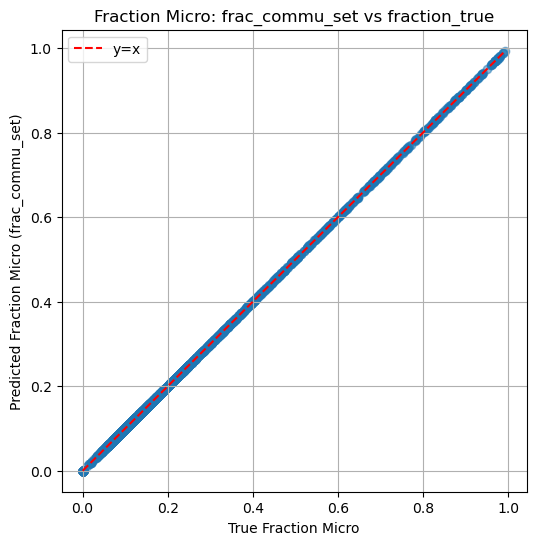

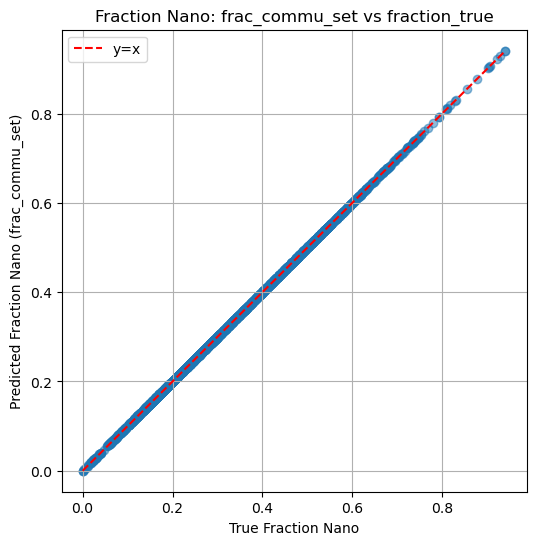

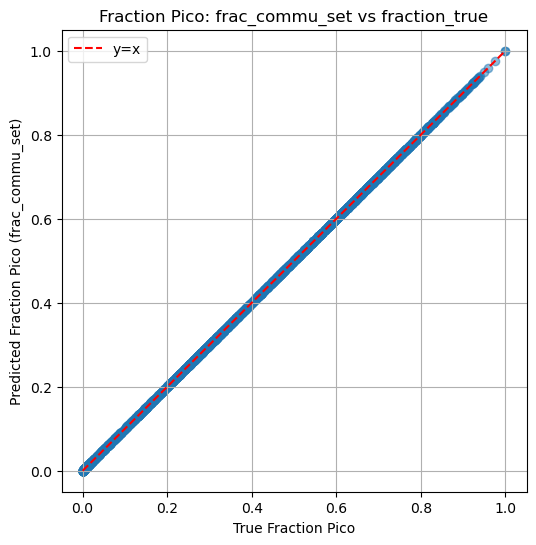

In [39]:
import matplotlib.pyplot as plt

# Conversion en numpy si nécessaire
frac_commu_np = frac_commu_set.numpy() if hasattr(frac_commu_set, 'numpy') else frac_commu_set
fraction_true_np = fraction_true.numpy() if hasattr(fraction_true, 'numpy') else fraction_true

labels = ['Micro', 'Nano', 'Pico']
for i in range(3):
    plt.figure(figsize=(6,6))
    plt.scatter(fraction_true_np[:, i], frac_commu_np[:, i], alpha=0.5)
    plt.plot([fraction_true_np[:, i].min(), fraction_true_np[:, i].max()],
             [fraction_true_np[:, i].min(), fraction_true_np[:, i].max()], 'r--', label='y=x')
    plt.xlabel(f'True Fraction {labels[i]}')
    plt.ylabel(f'Predicted Fraction {labels[i]} (frac_commu_set)')
    plt.title(f'Fraction {labels[i]}: frac_commu_set vs fraction_true')
    plt.legend()
    plt.grid(True)
    plt.show()

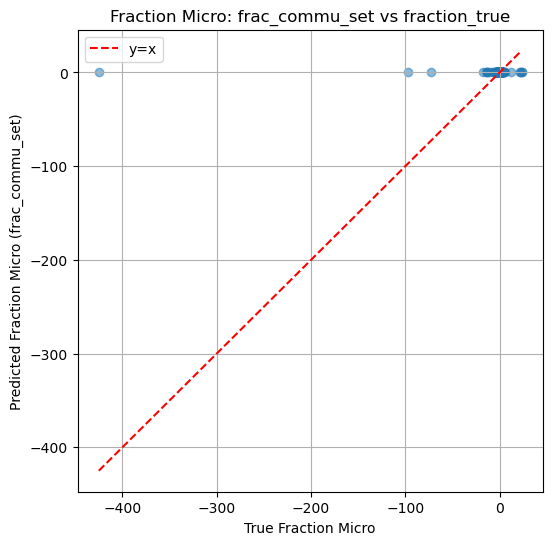

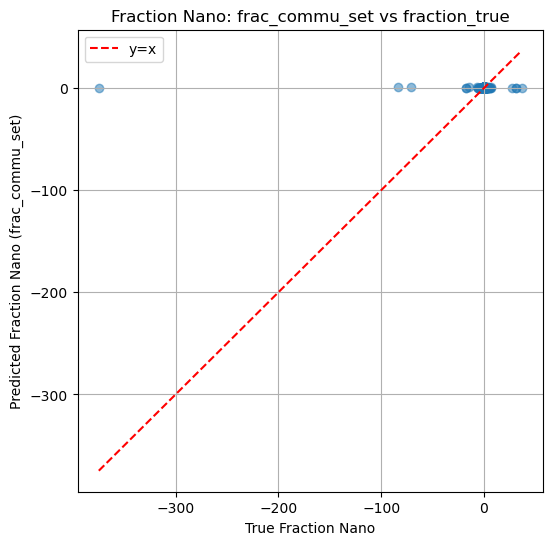

IndexError: index 2 is out of bounds for axis 1 with size 2

<Figure size 600x600 with 0 Axes>

In [63]:
import matplotlib.pyplot as plt

# Conversion en numpy si nécessaire
frac_commu_np = frac_commu_set.numpy() if hasattr(frac_commu_set, 'numpy') else frac_commu_set
fraction_true_np = fraction_pred.numpy() if hasattr(fraction_pred, 'numpy') else fraction_pred

labels = ['Micro', 'Nano', 'Pico']
for i in range(3):
    plt.figure(figsize=(6,6))
    plt.scatter(fraction_true_np[:, i], frac_commu_np[:, i], alpha=0.5)
    plt.plot([fraction_true_np[:, i].min(), fraction_true_np[:, i].max()],
             [fraction_true_np[:, i].min(), fraction_true_np[:, i].max()], 'r--', label='y=x')
    plt.xlabel(f'True Fraction {labels[i]}')
    plt.ylabel(f'Predicted Fraction {labels[i]} (frac_commu_set)')
    plt.title(f'Fraction {labels[i]}: frac_commu_set vs fraction_true')
    plt.legend()
    plt.grid(True)
    plt.show()

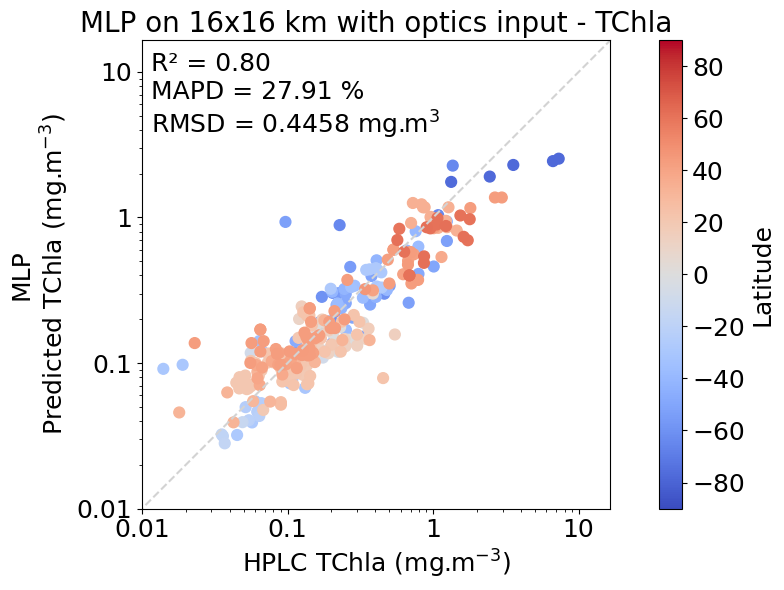

/tmp/ipykernel_2454507/2234649304.py:109: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipykernel_2454507/2234649304.py:110: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



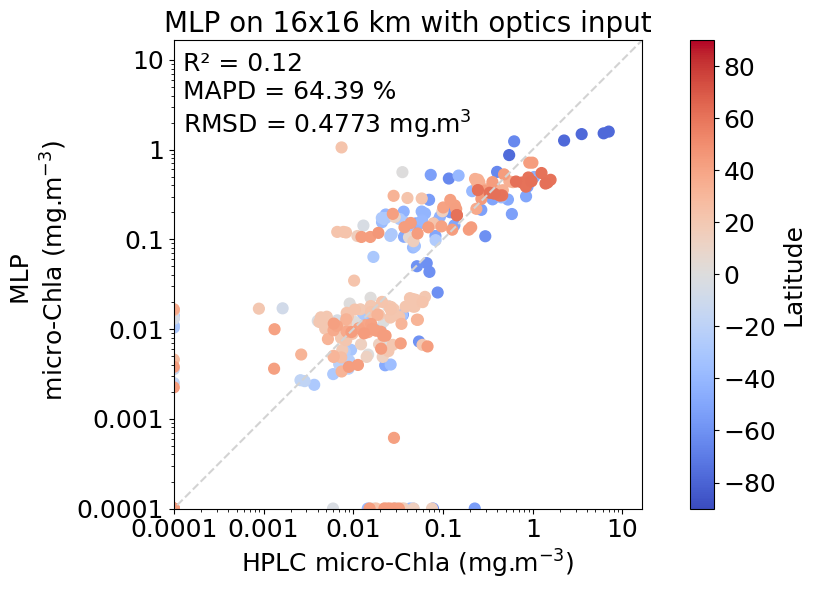

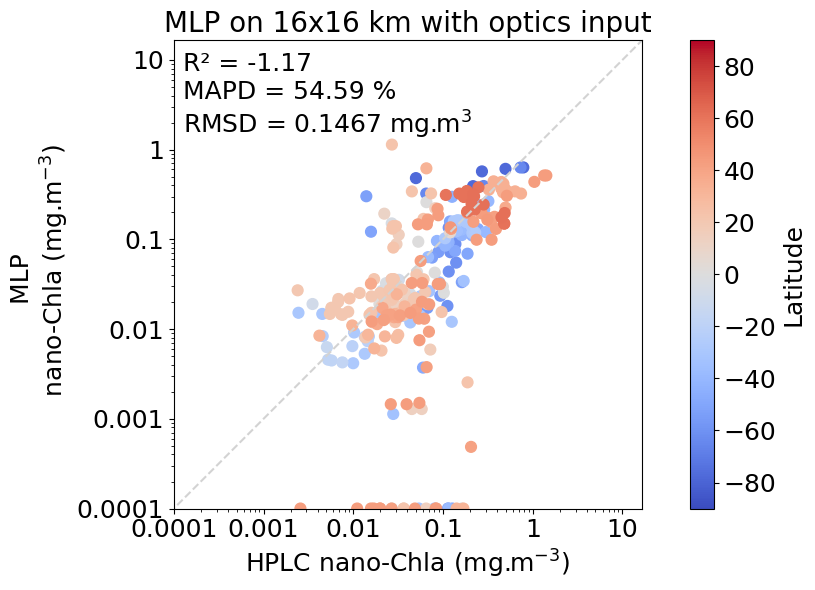

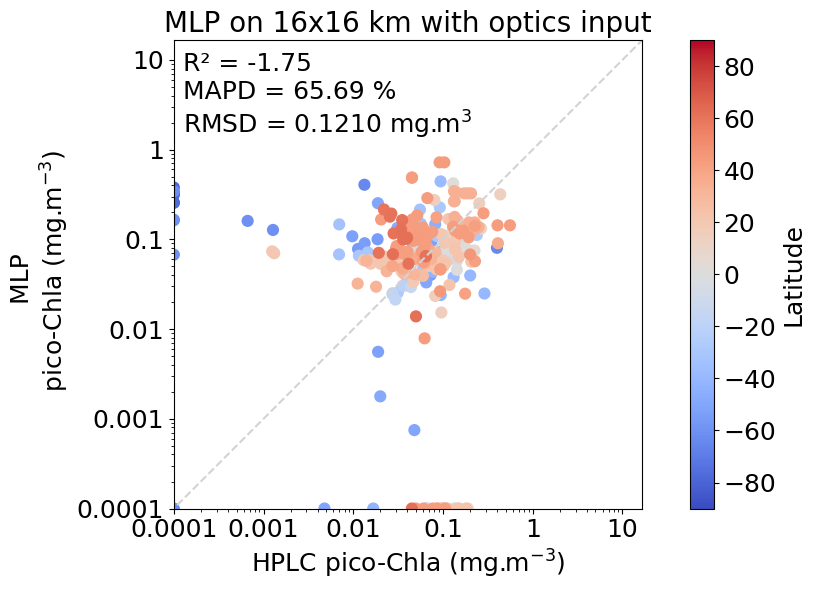

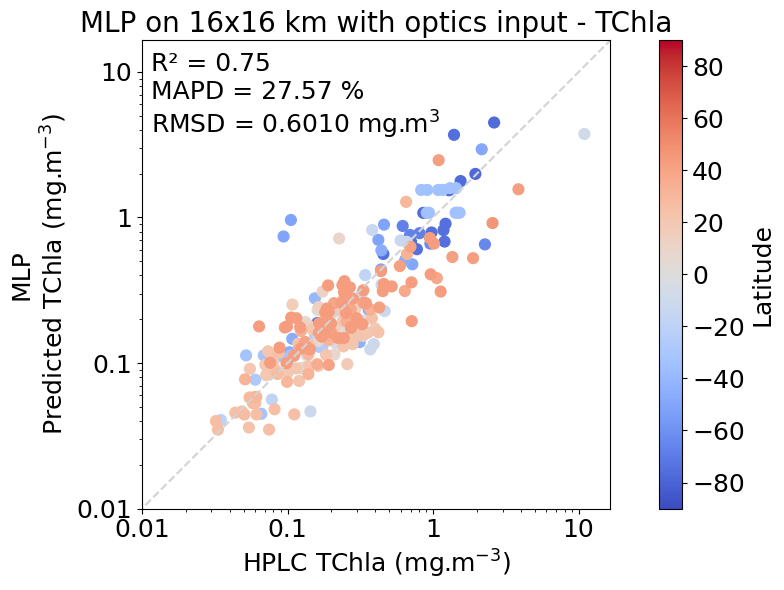

/tmp/ipykernel_2454507/2234649304.py:109: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipykernel_2454507/2234649304.py:110: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



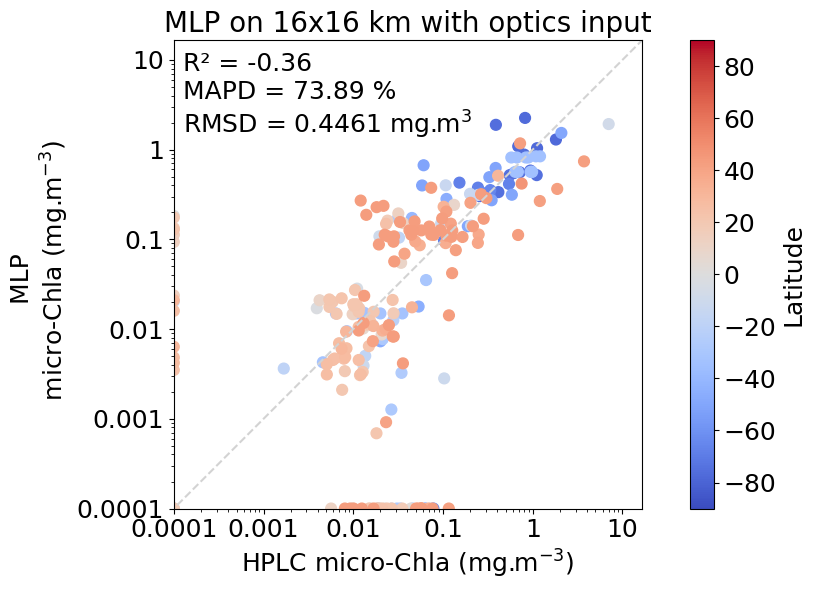

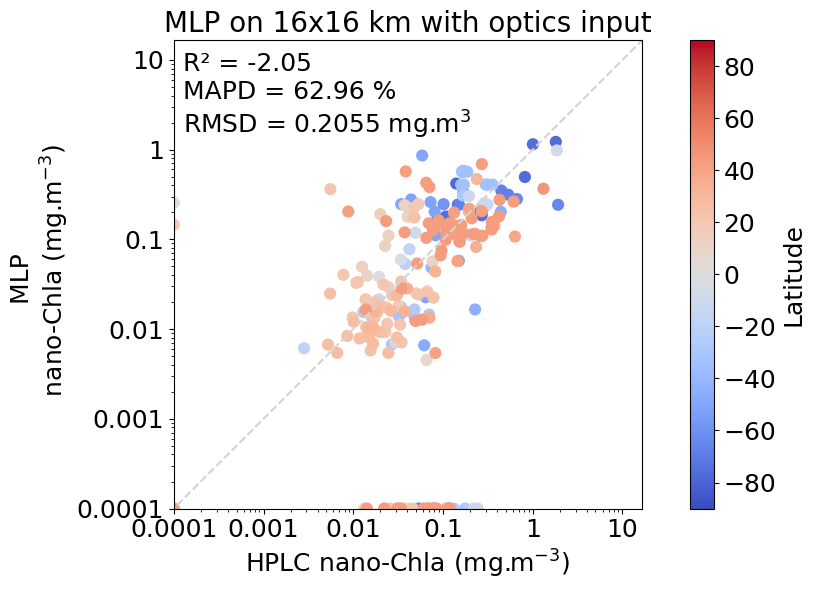

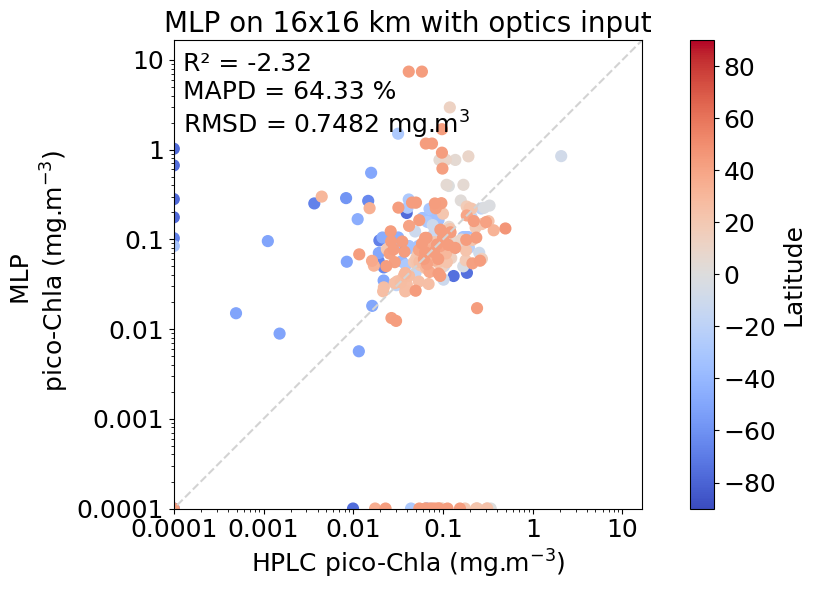

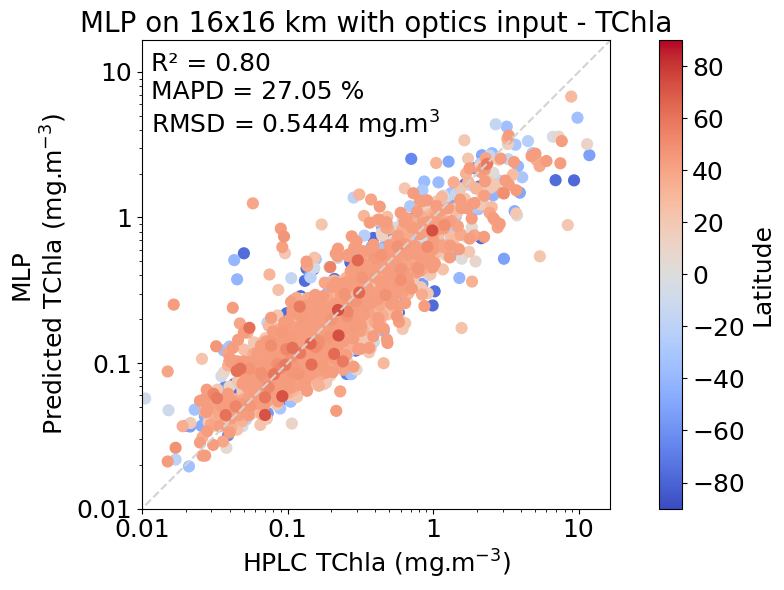

/tmp/ipykernel_2454507/2234649304.py:109: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipykernel_2454507/2234649304.py:110: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



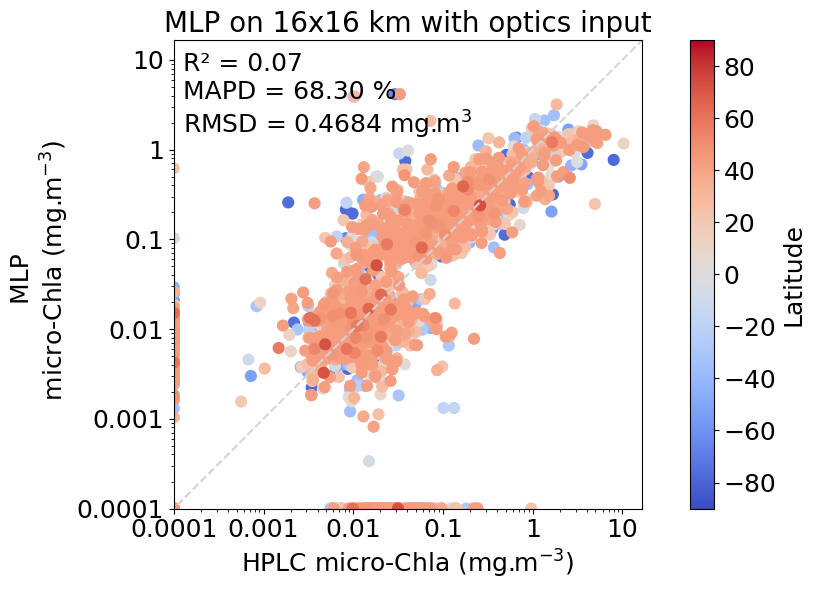

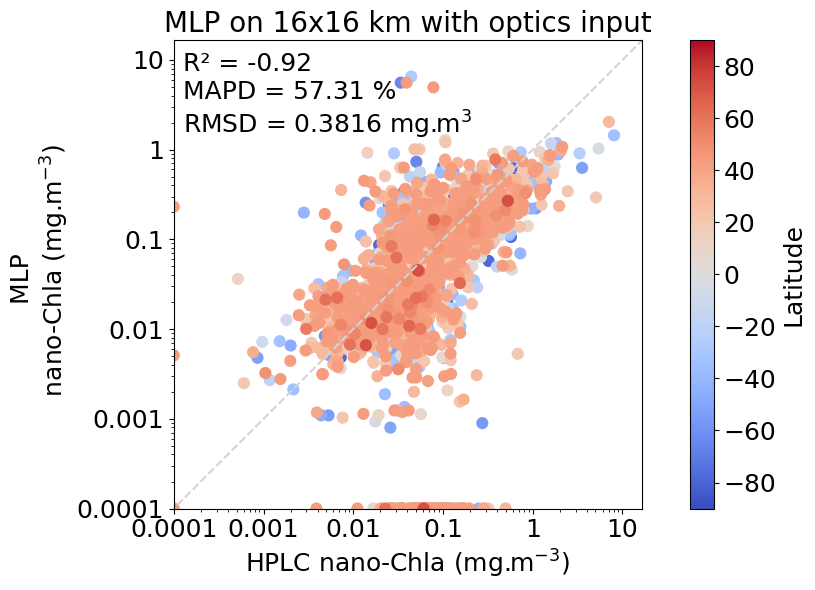

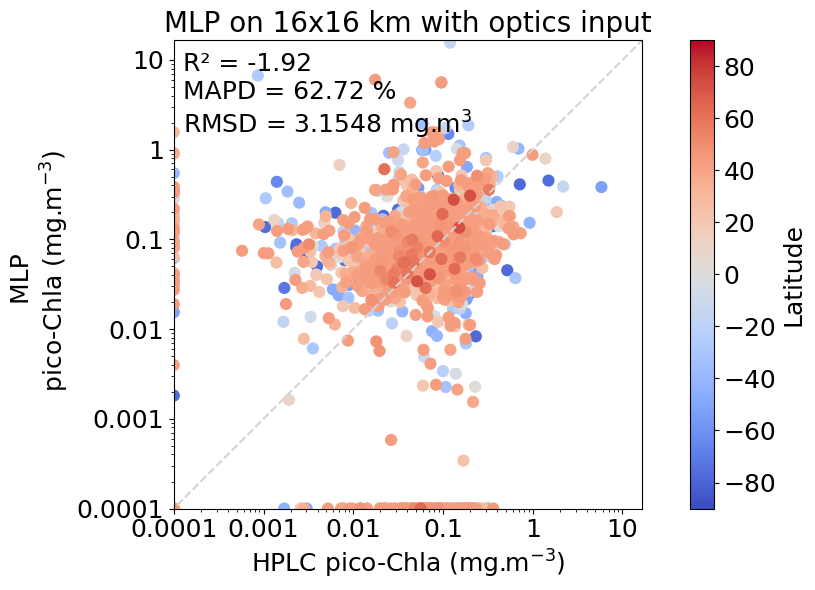

In [34]:
def evaluate_model(dataloader, model_trained, model, device, pfts, path_dico, df_mini_cubes, y_label_name, main_title, path_save_all, data_to_use, suffix, set_type, prediction_train_tchla=None, prediction_val_tchla=None, prediction_test_tchla=None):
    import os
    import json
    from scipy.special import inv_boxcox

    # Map pour filtrage selon set_type
    set_code_map = {'train': 0, 'val': 1, 'test': 2}
    set_code = set_code_map[set_type]

    # Sélectionner la bonne prédiction tchla selon le set
    if set_type == 'train':
        prediction_X_tchla = prediction_train_tchla
    elif set_type == 'val':
        prediction_X_tchla = prediction_val_tchla
    elif set_type == 'test':
        prediction_X_tchla = prediction_test_tchla
    else:
        raise ValueError(f"set_type inconnu: {set_type}")

    model_trained.eval()
    prediction_set = []
    true_set = []
    frac_commu_set = []
    idx = 0

    with torch.no_grad():
        for images, labels, _, _, frac_commu, tchla_pred in dataloader:
            tchla_pred = tchla_pred.unsqueeze(1)  
            images = images.to(device)
            if model != 3:
                images[images == -10] = float('nan')
                images = images.nanmean(dim=(2, 3))
            outputs = model_trained(images.float())

            # Ajout de la prédiction pico
            micro_pred = outputs[:, 0].view(-1, 1)
            nano_pred = outputs[:, 1].view(-1, 1)
            micro_pred = micro_pred.to(device)
            nano_pred = nano_pred.to(device)
            tchla_pred = tchla_pred.to(device)
            pico_pred = tchla_pred - micro_pred - nano_pred

            # Concaténer micro, nano, pico
            all_pred = torch.cat([micro_pred, nano_pred, pico_pred], dim=1)
            prediction_set.append(all_pred.cpu())
            true_set.append(labels.cpu())
            frac_commu_set.append(frac_commu.cpu())
            idx += len(images)

    prediction_set = torch.cat(prediction_set, dim=0)
    true_set = torch.cat(true_set, dim=0)
    frac_commu_set = torch.cat(frac_commu_set, dim=0)

    ## TCHLA ##
    prediction_sum = prediction_set.sum(dim=1)
    true_sum = true_set.sum(dim=1)

    # Make the fraction community 
    fraction_pred = prediction_set / prediction_sum.unsqueeze(1)  
    fraction_true = true_set / true_sum.unsqueeze(1)  

    # select the set based on the set_code
    df_set = df_mini_cubes[df_mini_cubes[:, 9] == set_code]
    df_set_lat = df_set[:, 0]

    key = "TChla"
    short_key = "tchla"
    
    predictions = {}
    truths = {}

    # Chargement dictionnaire
    json_path = os.path.join(path_dico, "dico_lambda_MLP.json")
    with open(json_path, "r") as f:
        dico = json.load(f)

    prediction_set = prediction_sum.cpu().numpy().reshape(-1, 1)
    true_set = true_sum.cpu().numpy().reshape(-1, 1)

    # Déstandardisation
    mean = dico[f"{key}_standardization_mean"]
    std = dico[f"{key}_standardization_std"]
    pred_i = prediction_set * std + mean
    true_i = true_set * std + mean

    # Déboxcox
    lmbda = dico[f"{key}_boxcox_lmbda"]
    pred_i = inv_boxcox(pred_i, lmbda)
    true_i = inv_boxcox(true_i, lmbda)

    # === Nouveau plot TChla vs TChla ===
    x_label = 'HPLC TChla (mg.m$^{-3}$)'
    y_label = f'{y_label_name}\nPredicted TChla (mg.m$^{{-3}}$)'
    output_file_tchla = os.path.join(path_save_all, f'tchla_vs_true_{suffix}.png')

    plot_score2(
        pred_i.flatten(),
        true_i.flatten(),
        main_title + " - TChla",
        df_set_lat,
        output_link=output_file_tchla,
        axis_log=True,
        xlabel=x_label,
        ylabel=y_label,
        PFTS=False
    )

    ## Obtain community ##
    prediction_community = fraction_pred * pred_i
    true_community = fraction_true * true_i

    prediction_community[prediction_community < 0.0001] = 0.0001
    true_community[true_community < 0.0001] = 0.0001
    predictions["micro"] = prediction_community[:, 0].tolist()
    predictions["nano"] = prediction_community[:, 1].tolist()
    predictions["pico"] = prediction_community[:, 2].tolist()

    truths["micro"] = true_community[:, 0].tolist()
    truths["nano"] = true_community[:, 1].tolist()
    truths["pico"] = true_community[:, 2].tolist()

    # Plots PFTs
    keys = ["Micro_Chla", "Nano_Chla", "Pico_Chla"]
    short_keys = ["micro", "nano", "pico"]
    for pft in short_keys:
        x_label = f'HPLC {pft}-Chla (mg.m$^{{-3}}$)'
        y_label = f'{y_label_name} \n {pft}-Chla (mg.m$^{{-3}}$)'
        output_file = os.path.join(path_save_all, f'{pft}_{suffix}_plot.png')

        plot_score2(
            predictions[pft],
            truths[pft],
            main_title,
            df_set_lat,
            output_link=output_file,
            axis_log=True,
            xlabel=x_label,
            ylabel=y_label,
            PFTS=True
        )

data_to_use = "boxcox"

evaluate_model(test_loader_pfts, model_trained, model, device, pfts, path_dico, df_mini_cubes, y_label_name, main_title, path_save_all, data_to_use, suffix="test", set_type="test", prediction_train_tchla=prediction_train_tchla, prediction_val_tchla=prediction_val_tchla, prediction_test_tchla=prediction_test_tchla)
evaluate_model(valid_loader_pfts, model_trained, model, device, pfts, path_dico, df_mini_cubes, y_label_name, main_title, path_save_all, data_to_use, suffix="val", set_type="val", prediction_train_tchla=prediction_train_tchla, prediction_val_tchla=prediction_val_tchla, prediction_test_tchla=prediction_test_tchla)
evaluate_model(train_loader_pfts, model_trained, model, device, pfts, path_dico, df_mini_cubes, y_label_name, main_title, path_save_all, data_to_use, suffix="train", set_type="train", prediction_train_tchla=prediction_train_tchla, prediction_val_tchla=prediction_val_tchla, prediction_test_tchla=prediction_test_tchla)



In [ ]:
model_save_name = "MLP.pth"
model_save_path = os.path.join(path_save_all, model_save_name)
torch.save({
        'epoch': nb_epoch, 
        'model_state_dict': model_trained.state_dict(), 
        'optimizer_state_dict': optimizer.state_dict() }, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./training_new_loss_pico_soustraction/model_1/space_buffer_8_date_buffer_1/train_pfts_2/MLP.pth


In [ ]:
# Visualisation interactive Plotly : KDE des TCHLA true et pred (train, val, test) avec remplissage sous les courbes
import plotly.graph_objs as go
import numpy as np
from scipy.stats import gaussian_kde

def kde_curve(data, bw_method=0.2, n_points=500):
    kde = gaussian_kde(data, bw_method=bw_method)
    x_grid = np.linspace(np.min(data), np.max(data), n_points)
    y_grid = kde(x_grid)
    return x_grid, y_grid

splits = [
    ('Train', tchla_train_trans['tchla_true_std'], tchla_train_trans['tchla_pred_std'], 'blue', 'blue', 'lightblue'),
    ('Validation', tchla_val_trans['tchla_true_std'], tchla_val_trans['tchla_pred_std'], 'green', 'green', 'lightgreen'),
    ('Test', tchla_test_trans['tchla_true_std'], tchla_test_trans['tchla_pred_std'], 'red', 'red', 'salmon')
]

fig = go.Figure()

# Ajout des courbes KDE et remplissage pour chaque split
for split_name, true_data, pred_data, true_color, pred_color, fill_color in splits:
    # KDE pour true
    x_true, y_true = kde_curve(true_data)
    fig.add_trace(go.Scatter(
        x=x_true, y=y_true,
        mode='lines',
        name=f'{split_name} True',
        line=dict(color=true_color, width=2),
        fill='tozeroy',
        fillcolor=fill_color,
        opacity=0.5
    ))
    # KDE pour pred
    x_pred, y_pred = kde_curve(pred_data)
    fig.add_trace(go.Scatter(
        x=x_pred, y=y_pred,
        mode='lines',
        name=f'{split_name} Pred',
        line=dict(color=pred_color, width=2, dash='dash'),
        fill='tozeroy',
        fillcolor=fill_color,
        opacity=0.3
    ))

fig.update_layout(
    title='KDE Plotly: Standardized log10(TCHLA True & Pred) - Train/Val/Test',
    xaxis_title='Standardized log10(TCHLA)',
    yaxis_title='Density',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

fig.show()

In [62]:
max_idx = fraction_pred.argmax().item()  # conversion explicite en int
max_val = fraction_pred.max().item()     # conversion explicite en float

# Trouver la ligne et la colonne
row, col = divmod(max_idx, fraction_pred.shape[1])

print(f"fraction_pred.max() = {max_val} at row {row}, col {col}")
print(f"prediction_sum[{row}] = {prediction_sum[row].item()}")
print(f"prediction_set[{row}, :] = {prediction_set[row, :].tolist()}")
print(f"fraction_true[{row}, {col}] = {fraction_true[row, col].item()}")


fraction_pred.max() = 36.49711227416992 at row 1678, col 1
prediction_sum[1678] = -0.524683952331543
prediction_set[1678, :] = [0.07447394728660583, -0.037269994616508484]
fraction_true[1678, 1] = 0.1955479383468628


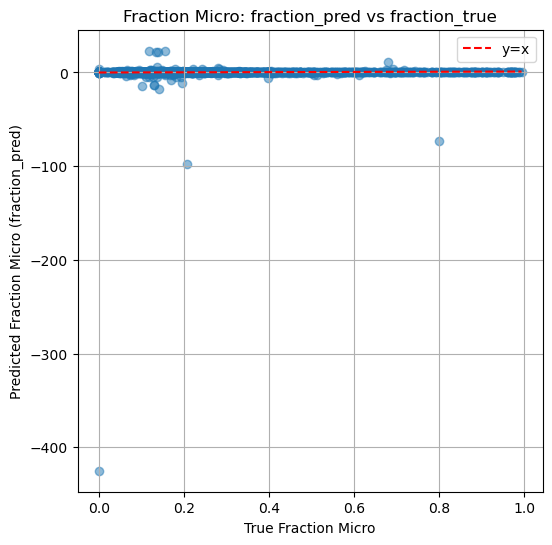

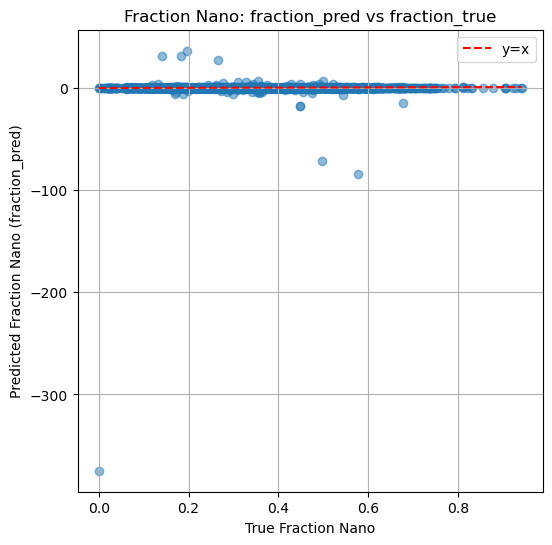

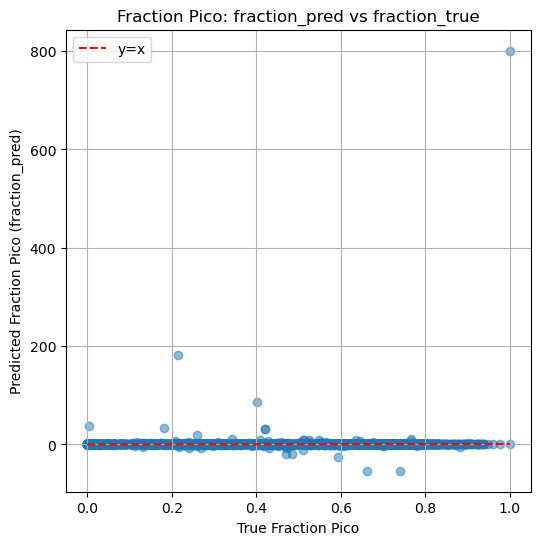

In [43]:
# Plot fraction_pred vs fraction_true pour chaque communauté
fraction_pred_np = fraction_pred.numpy() if hasattr(fraction_pred, 'numpy') else fraction_pred
fraction_true_np = fraction_true.numpy() if hasattr(fraction_true, 'numpy') else fraction_true

labels = ['Micro', 'Nano', 'Pico']
for i in range(3):
    plt.figure(figsize=(6,6))
    plt.scatter(fraction_true_np[:, i], fraction_pred_np[:, i], alpha=0.5)
    plt.plot([fraction_true_np[:, i].min(), fraction_true_np[:, i].max()],
             [fraction_true_np[:, i].min(), fraction_true_np[:, i].max()], 'r--', label='y=x')
    plt.xlabel(f'True Fraction {labels[i]}')
    plt.ylabel(f'Predicted Fraction {labels[i]} (fraction_pred)')
    plt.title(f'Fraction {labels[i]}: fraction_pred vs fraction_true')
    plt.legend()
    plt.grid(True)
    plt.show()


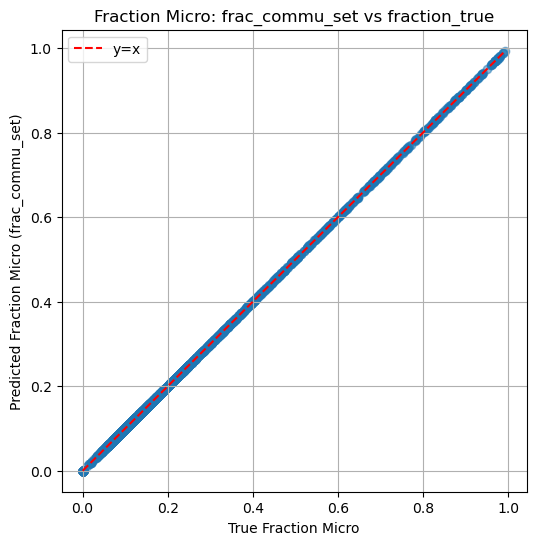

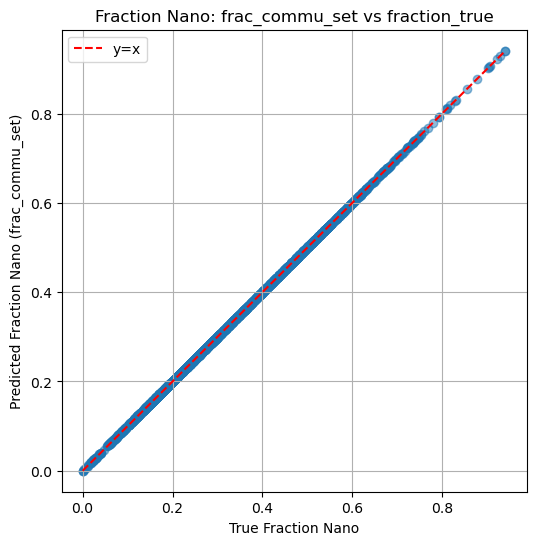

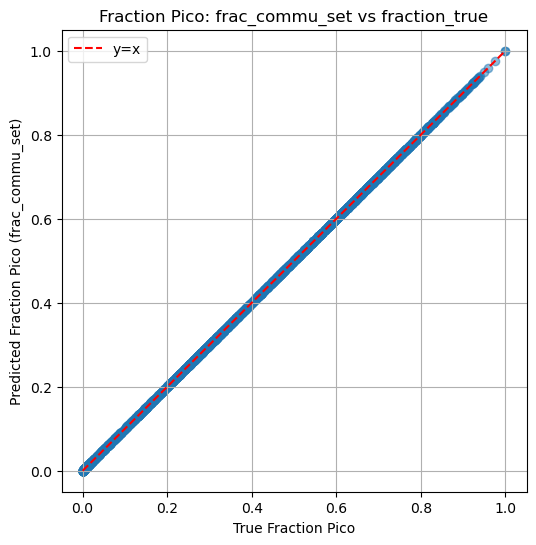

In [38]:
import matplotlib.pyplot as plt

# Conversion en numpy si nécessaire
frac_commu_np = frac_commu_set.numpy() if hasattr(frac_commu_set, 'numpy') else frac_commu_set
fraction_true_np = fraction_true.numpy() if hasattr(fraction_true, 'numpy') else fraction_true

labels = ['Micro', 'Nano', 'Pico']
for i in range(3):
    plt.figure(figsize=(6,6))
    plt.scatter(fraction_true_np[:, i], frac_commu_np[:, i], alpha=0.5)
    plt.plot([fraction_true_np[:, i].min(), fraction_true_np[:, i].max()],
             [fraction_true_np[:, i].min(), fraction_true_np[:, i].max()], 'r--', label='y=x')
    plt.xlabel(f'True Fraction {labels[i]}')
    plt.ylabel(f'Predicted Fraction {labels[i]} (frac_commu_set)')
    plt.title(f'Fraction {labels[i]}: frac_commu_set vs fraction_true')
    plt.legend()
    plt.grid(True)
    plt.show()
